In [97]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import fsspec
import math

import xarray as xr
xr.set_options(display_style="html")  # display dataset nicely

import warnings
warnings.simplefilter("ignore")  # filter some warning messages

# code features from https://scitools.org.uk/cartopy/docs/v0.14/matplotlib/feature_interface.html
crs = ccrs.PlateCarree()  # set projection

In [98]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

from pathlib import Path

# Small style adjustments for more readable plots
plt.style.use("seaborn-whitegrid")
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["font.size"] = 14

In [99]:
ds = xr.open_dataset("~/shared/climate-data/ds_hw.nc")

In [100]:
#latitude and longitude of the locations
mont = {"name": "Monterey", "lat": 36.598, "lon": -121.8922}
newport = {"name": "Newport", "lat": 45, "lon": -124.061}

In [101]:
#calculate offshore longitude, default distance: 1000 km 
def offshore_coordinate(curr_lat, curr_lon, d=1000):
    Earthradius = 6378
    curr_lon_radian = curr_lon * math.pi/180
    curr_lat_radian = curr_lat * math.pi/180
    
    latitude_radius = Earthradius * math.cos(curr_lat_radian)
    longitude = (curr_lon_radian - d/latitude_radius)*180/math.pi
    
    return longitude

In [105]:
#SST at the offshore location 
mont_offshore_lon = offshore_coordinate(mont['lat'], mont['lon'], d=1000)
mont_offshore_lat = mont['lat']

#30 day running mean (converting temperature from kelvin to celsius)
averaged_SST = ds.analysed_sst.sel(lat=mont_offshore_lat,
                      lon=mont_offshore_lon, 
                      method='nearest').rolling(time=30, center=True).mean() - 273.15

SST_2014 = averaged_SST.sel(time="2014")
SST_2015 = averaged_SST.sel(time="2015")
SST_2016 = averaged_SST.sel(time="2016")

In [106]:
ds_0213 = averaged_SST.sel(time=slice("2002", "2013"))
SST_0213_mean = ds_0213.groupby(ds_0213["time.dayofyear"]).mean()
SST_0213_max = ds_0213.groupby(ds_0213["time.dayofyear"]).max()
SST_0213_min = ds_0213.groupby(ds_0213["time.dayofyear"]).min()
SST_0213_std = ds_0213.groupby(ds_0213["time.dayofyear"]).std()
SST_0213_upper_1sd = SST_0213_mean + SST_0213_std
SST_0213_lower_1sd = SST_0213_mean - SST_0213_std

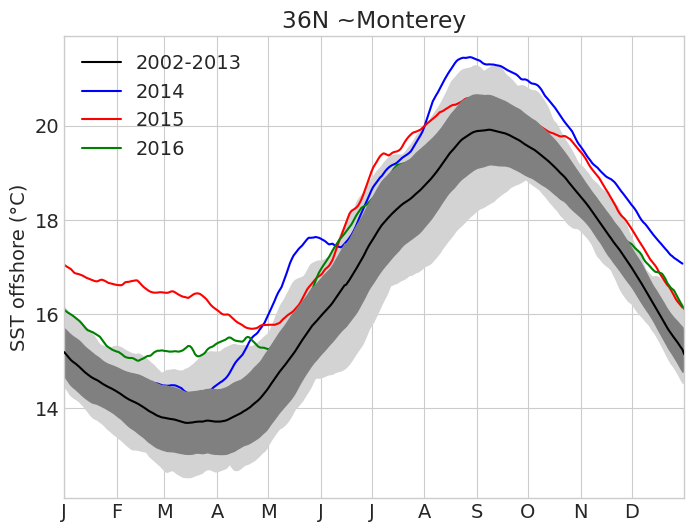

In [125]:
plt.plot(SST_0213_mean, color="black", label="2002-2013", zorder=3)
plt.fill_between(list(range(len(SST_0213_mean))), SST_0213_max, SST_0213_min, color="lightgray", zorder=1)
plt.fill_between(list(range(len(SST_0213_mean))), SST_0213_upper_1sd, SST_0213_lower_1sd, color="gray", zorder=2)
plt.plot(SST_2014, color="blue", label="2014", zorder=1)
plt.plot(SST_2015, color="red", label="2015", zorder=1)
plt.plot(SST_2016, color="green", label="2016", zorder=1)


plt.legend(loc="upper left")

plt.title("36N ~Monterey")
plt.ylabel("SST offshore (°C)")
plt.xlim(0, 365)
plt.xticks([0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334]
           , ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']);